In [ ]:
# !pip install yfinance tensorflow pandas scikit-learn

# Coleta de Dados

[*********************100%***********************]  1 of 1 completed


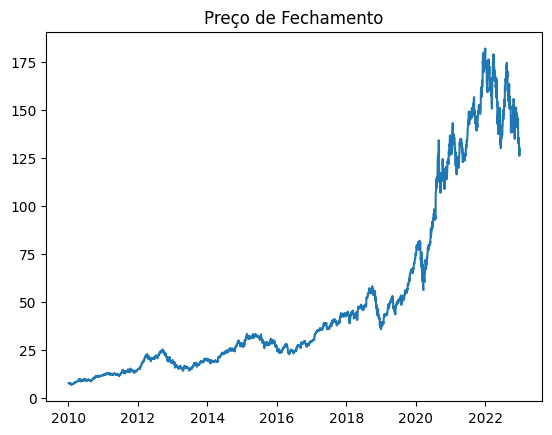

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense


# Coleta de dados da ação usando yfinance
def coletar_dados(ticker, start_date, end_date):
    dados = yf.download(ticker, start=start_date, end=end_date)
    dados = dados[['Close']]  # Usamos apenas o preço de fechamento
    return dados

ticker = 'AAPL'  # Exemplo usando Apple
start_date = '2010-01-01'
end_date = '2023-01-01'
dados = coletar_dados(ticker, start_date, end_date)

# Visualizando os dados
plt.plot(dados)
plt.title('Preço de Fechamento')
plt.show()


# Treinamento

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalizar os dados para ficar entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
dados_escalados = scaler.fit_transform(dados)

# Criar as sequências de lag
def criar_sequencias(dados, look_back=40):
    X, y = [], []
    for i in range(look_back, len(dados)):
        X.append(dados[i-look_back:i, 0])
        y.append(dados[i, 0])
    return np.array(X), np.array(y)

# 40 dias de lag features
look_back = 40
X, y = criar_sequencias(dados_escalados, look_back)

# Reshape X para a forma [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [ ]:
# Dividir em conjunto de treinamento (80%) e teste (20%)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:


# Criar o modelo LSTM
model = Sequential()

# Camada LSTM com Dropout (20%)
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))

# Segunda camada LSTM com Dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Camada densa para saída
model.add(Dense(units=1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0064 - val_loss: 0.0013
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 3.5912e-04 - val_loss: 0.0013
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 2.8909e-04 - val_loss: 0.0016
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.9262e-04 - val_loss: 0.0012
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 2.3564e-04 - val_loss: 0.0014
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 2.8869e-04 - val_loss: 0.0018
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.1269e-04 - val_loss: 0.0017
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.7674e-04 - val_loss: 0.0014
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 2.0242e-04 - val_loss: 0.0010
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.0929e-04 - val_loss: 0.0011
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.0472e-04 - val_loss: 0.0043
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━

# Avaliação

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
MAE: 6.23186112039793
RMSE: 7.453152580071532
MAPE: 4.430219442633332%


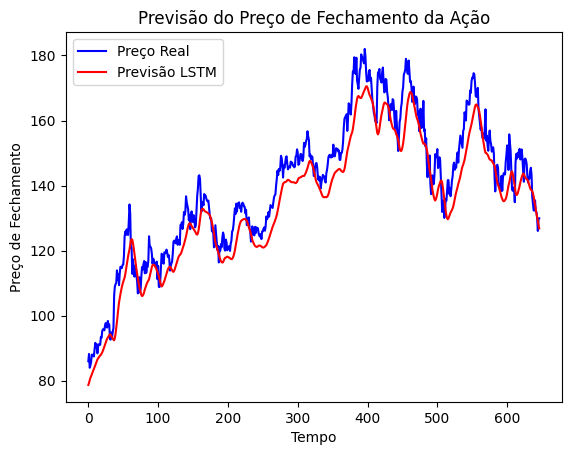

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Previsões no conjunto de teste
predicoes = model.predict(X_test)

# Desescalar as previsões para voltar à escala original
predicoes_desescaladas = scaler.inverse_transform(predicoes)

# Desescalar os dados reais de teste
y_test_desescalado = scaler.inverse_transform(y_test.reshape(-1, 1))

# Cálculo das métricas
mae = mean_absolute_error(y_test_desescalado, predicoes_desescaladas)
rmse = np.sqrt(mean_squared_error(y_test_desescalado, predicoes_desescaladas))
mape = np.mean(np.abs((y_test_desescalado - predicoes_desescaladas) / y_test_desescalado)) * 100

# Exibir as métricas
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

# Plotar os resultados
plt.plot(y_test_desescalado, color='blue', label='Preço Real')
plt.plot(predicoes_desescaladas, color='red', label='Previsão LSTM')
plt.title('Previsão do Preço de Fechamento da Ação')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()


# Otimização

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


# Adicionar early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recompilar e treinar o modelo com early stopping
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping])


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 2.0640e-04 - val_loss: 0.0024
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 1.6495e-04 - val_loss: 0.0013
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 1.3814e-04 - val_loss: 0.0025
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1.4206e-04 - val_loss: 7.4559e-04
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.2938e-04 - val_loss: 9.1756e-04
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.4235e-04 - val_loss: 0.0031
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 1.2061e-04 - val_loss: 6.7579e-04
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 1.1689e-04 - val_loss: 6.6983e-04
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1.4159e-04 - val_loss: 0.0012
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 9.8455e-05 - val_loss: 0.0022
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.4645e-04 - val_loss:

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Métricas após otimização:
MAE: 3.1165641301197837
RMSE: 4.089312060597674
MAPE: 2.238163968683226%


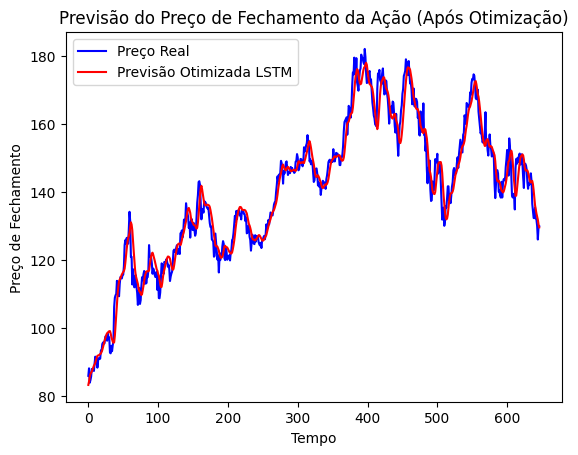

In [ ]:
# Fazer previsões no conjunto de teste após otimização
predicoes_otimizada = model.predict(X_test)

# Desescalar as previsões para valores originais
predicoes_otimizada_desescaladas = scaler.inverse_transform(predicoes_otimizada)

# Desescalar os valores reais de teste
y_test_desescalado = scaler.inverse_transform(y_test.reshape(-1, 1))

# Cálculo das métricas após a otimização
mae_otimizado = mean_absolute_error(y_test_desescalado, predicoes_otimizada_desescaladas)
rmse_otimizado = np.sqrt(mean_squared_error(y_test_desescalado, predicoes_otimizada_desescaladas))
mape_otimizado = np.mean(np.abs((y_test_desescalado - predicoes_otimizada_desescaladas) / y_test_desescalado)) * 100

# Exibir as métricas após otimização
print(f'Métricas após otimização:')
print(f'MAE: {mae_otimizado}')
print(f'RMSE: {rmse_otimizado}')
print(f'MAPE: {mape_otimizado}%')

# Plotar o gráfico de previsões otimizadas
plt.plot(y_test_desescalado, color='blue', label='Preço Real')
plt.plot(predicoes_otimizada_desescaladas, color='red', label='Previsão Otimizada LSTM')
plt.title('Previsão do Preço de Fechamento da Ação (Após Otimização)')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

# Recursividade e retro alimentação

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
                       Data  Previsão de Fechamento
0 2022-12-31 00:00:00+00:00              129.599442
1 2023-01-01 00:00:00+00:00              129.166153
2 2023-01-02 00:00:00+00:00              128.974289
3 2023-01-03 00:00:00+00:00              128.930389
4 2023-01-04 00:00:00+00:00              128.981430
5 2023-01-05 00:00:00+00:00              129.096588
6 2023-01-06 00:00:00+00:00              129.257217


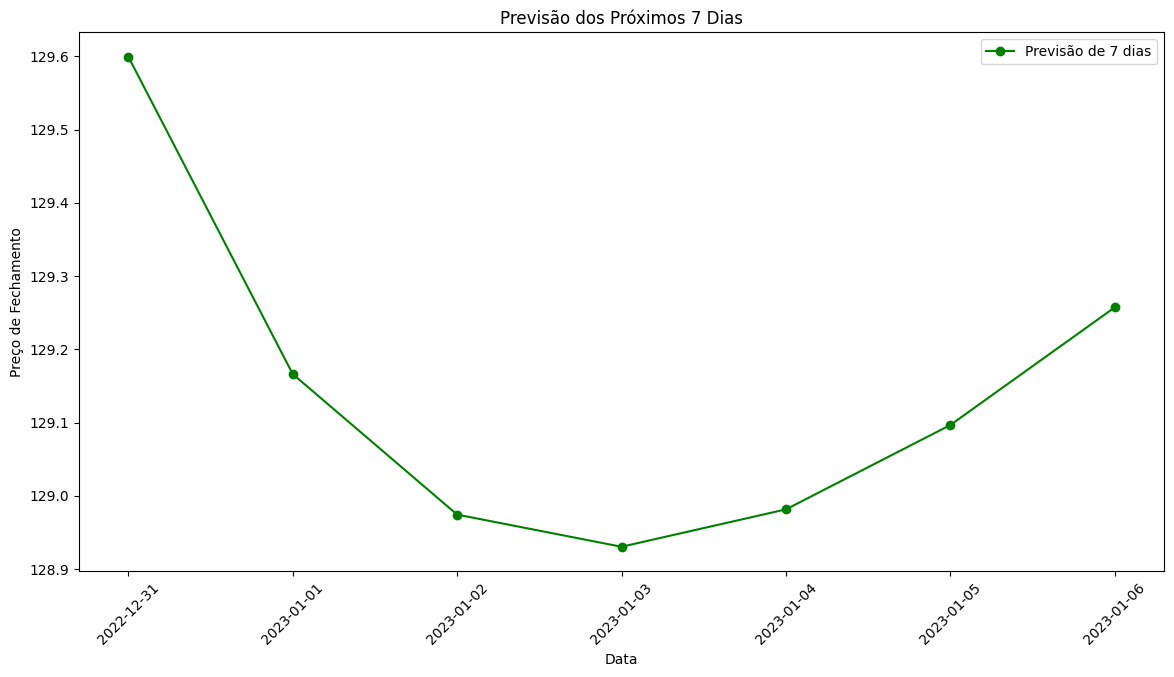

In [ ]:
from datetime import timedelta

# 11. Prever os próximos 7 dias
def gerar_datas_futuras(data_inicial, dias):
    return [data_inicial + timedelta(days=i) for i in range(1, dias+1)]

def prever_multiplos_dias(model, dados_iniciais, dias_previsao, look_back, scaler):
    previsoes_futuras = []
    dados = dados_iniciais.copy()

    for _ in range(dias_previsao):
        ultima_sequencia = dados[-look_back:]
        ultima_sequencia_reshape = np.reshape(ultima_sequencia, (1, look_back, 1))
        previsao = model.predict(ultima_sequencia_reshape)
        previsoes_futuras.append(previsao[0, 0])
        dados = np.append(dados, previsao, axis=0)

    previsoes_futuras_desescaladas = scaler.inverse_transform(np.array(previsoes_futuras).reshape(-1, 1))
    return previsoes_futuras_desescaladas

# Última data do conjunto de teste
ultima_data = dados.index[-1]
# Gerar as próximas 7 datas
datas_futuras = gerar_datas_futuras(ultima_data, 7)

# Fazer a previsão para os próximos 7 dias
dados_iniciais = X_test[-1].reshape(-1, 1)
previsoes_futuras = prever_multiplos_dias(model, dados_iniciais, 7, look_back, scaler)

# Exibir previsões com as datas
previsoes_df = pd.DataFrame({
    'Data': datas_futuras,
    'Previsão de Fechamento': previsoes_futuras.flatten()
})
print(previsoes_df)

# Plotar previsões futuras com as datas
plt.figure(figsize=(14, 7))
plt.plot(datas_futuras, previsoes_futuras, color='green', marker='o', label='Previsão de 7 dias')
plt.title('Previsão dos Próximos 7 Dias')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotacionar as datas para melhorar a visualização
plt.legend()
plt.show()

In [ ]:
model.save('modelo_lstm_previsao.h5')
